## Optimization with tuned surrogate hyperparameters

Sometimes we want to carefully ensure that the tree ensemble we are using to build an optimization model has the right complexity. The default hyperparameters, like the number of trees, tree depth, and the minimum number of observations allowed in terminal leaves, may lead to over- or underfitting, resulting in the optimizer needing a larger number of expensive black-box function evaluations to find good experimental settings.

We can easily improve the situation by tuning the tree ensemble parameters with cross validation. We can do this as often as we please - the minimal approach would be to tune the hyperparameters once before the first proposal and retain those hyperparameters for all other iterations. If we are willing to wait, on the other hand, we could retune the hyperparameters after every iteration.

### Environment setup

The optimization problem in this example can get too large to solve with the free version of Gurobi, so here we use a server running in the cloud. We use .env to store the cloud credentials so that no secret information appears in this example. I also have a `gurobi.env` file in the current working directory containing the line `OutputFlag 0` to suppress output, since we are calling Gurobi lots of times in this example.

In [97]:
from dotenv import load_dotenv
import os

# Define the Gurobi server access parameters in a .env file
# load_dotenv reads from .env and defines the environment variables
# we use below
load_dotenv()

# You can also just define this dict directly, but it's good practise to avoid
# having the credentials hard-coded or visible in plaintext
connection_params = {
    "CLOUDACCESSID": os.getenv("CLOUDACCESSID"),
    "CLOUDSECRETKEY": os.getenv("CLOUDSECRETKEY"),
    "CLOUDPOOL": os.getenv("CLOUDPOOL"),
}

### Problem setup

First we will construct a problem by hand. We will have a function to simulate doing experiments; in real applications this would be some expensive experiment or simulation.

In [98]:
import numpy as np


def blackbox_ground_truth(x: np.ndarray) -> np.ndarray:
    """Get the ground truth response for each observation in a dataset

    The input array is N_observations x N_input_features and the output
    of this function is a column vector with N_observations elements

    Note for Nathan: I think this problem I invented is not a good one 
    to demonstrate GBT complexity. I'm sure you have a better idea.
    """

    def evaluate_blackbox_single_obs(xin, noise_std=0.1):
        if xin[0] == "add1":
            return np.random.normal(loc=0, scale=noise_std) - xin[2]*np.exp(
                -((xin[3] - 5.5) ** 2) / (2 * 0.2)
            )
        if xin[0] == "add2":
            return (
                xin[1] / 10
                + 0.5*xin[1]*np.cos(xin[3] * 12) * (xin[3] - 5.75)**2
                + np.random.normal(loc=0, scale=noise_std)
            )
        if xin[0] == "add3":
            return (
                xin[2]
                + np.random.normal(loc=0, scale=noise_std)
            )

    return np.array([evaluate_blackbox_single_obs(xobs) for xobs in x]).reshape(-1, 1)

Next we generate an initial training data set and put the ProblemConfig object together.

In [99]:
from entmoot import Enting, ProblemConfig, GurobiOptimizer
import numpy as np


# define problem
problem_config = ProblemConfig(rnd_seed=10)
problem_config.add_feature("categorical", ("add1", "add2", "add3"))
problem_config.add_feature("integer", (5, 10))
problem_config.add_feature("binary")
problem_config.add_feature("real", (5.0, 6.0))
problem_config.add_min_objective()

# sample data for training. This is the intial dataset from before the
# iterative optimization started
N_init_samples = 30
rnd_sample = problem_config.get_rnd_sample_list(num_samples=N_init_samples)
rnd_sample_outcomes = blackbox_ground_truth(rnd_sample)

### Optimization with default hyperparameters

To show the effect of tuned vs default hyperparameters we will perform the optimization two times. Here we leave the tree ensemble hyperparameters untouched and perform 50 Bayesian optimization iterations.

In [100]:
from itertools import chain
import gurobipy as gp

N_iterations = 50
params = {"unc_params": {"dist_metric": "l1", "acq_sense": "exploration", "beta": 1.5}}
enting = Enting(problem_config, params=params)
params_gurobi = {"MIPGap": 0}
opt_gur = GurobiOptimizer(problem_config, params=params_gurobi)

# Remember the proposals and outcomes in these variables
opt_trajectory_inputs = []
opt_trajectory_outputs = np.empty((N_iterations, 1))

# The context manager here is needed for the Gurobi cloud server
with gp.Env(params=connection_params) as env:
    for idx in range(N_iterations):
        # Put together the initial dataset and any optimization iterations
        # we have done so far
        x = [_ for _ in chain(rnd_sample, opt_trajectory_inputs)]
        y = np.concatenate(
            (rnd_sample_outcomes, opt_trajectory_outputs[:idx, :]), axis=0
        )

        enting.fit(x, y)
        res_gur = opt_gur.solve(enting, use_env=True)

        opt_trajectory_inputs.append(tuple(xopt for xopt in res_gur.opt_point))
        opt_trajectory_outputs[idx, 0] = blackbox_ground_truth(opt_trajectory_inputs)[-1,0]

C:\Users\leer8\dev\entmootv2_testing\entmoot\entmoot\models\mean_models\tree_ensemble.py:23: UserWarning: No 'train_params' for tree ensemble training specified. Switch training to default params!
  warnings.warn(


Let's see how the optimization went.

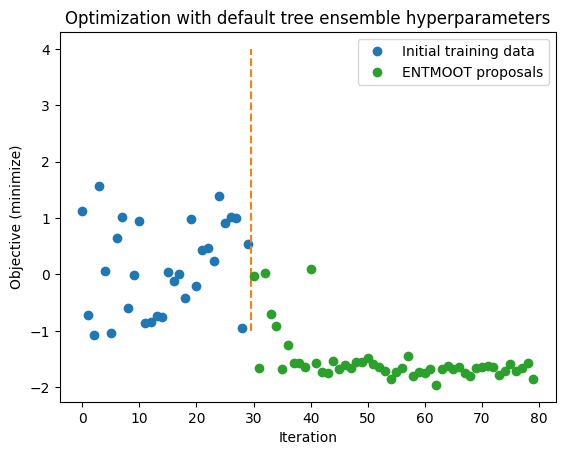

In [109]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(N_init_samples), rnd_sample_outcomes, "o", label="Initial training data")
ax.plot([N_init_samples - 0.5, N_init_samples - 0.5], [-1, 4], "--")
ax.plot(np.arange(N_iterations) + N_init_samples, opt_trajectory_outputs, "o", label="ENTMOOT proposals")
ax.set_xlabel("Iteration")
ax.set_ylabel("Objective (minimize)")
ax.set_title("Optimization with default tree ensemble hyperparameters")
ax.legend()
plt.show()

### Improving the tree ensemble hyperparameters

Now we take the initial dataset and try a few different hyperparameter combinations for the boosted tree model. We'll keep the best ones we find, run the optimization again, and see what performance we get. We will use the cross validation error to evaluate the quality of each hyperparameter combination.

First we define the random hyperparameter values that we will try:

In [102]:
N_hyperpar_pts = 100

boosting_rounds = np.random.randint(
    low=np.ones(N_hyperpar_pts) * 40, high=np.ones(N_hyperpar_pts) * 500
)
max_depths = np.random.randint(
    low=np.ones(N_hyperpar_pts) * 1, high=np.ones(N_hyperpar_pts) * 5
)
min_data_in_leafs = np.random.randint(
    low=np.ones(N_hyperpar_pts) * 1, high=np.ones(N_hyperpar_pts) * 5
)
learning_rates = 10 ** (-np.random.random(N_hyperpar_pts) * 5)

params_to_try = [
    {
        "train_params": {
            "objective": "regression",
            "metric": "rmse",
            "boosting": "gbdt",
            "num_boost_round": nbr,
            "max_depth": md,
            "min_data_in_leaf": mdil,
            "min_data_per_group": 1,
            "learning_rate": lr,
            "verbose": -1,
        }
    }
    for nbr, md, mdil, lr in zip(
        boosting_rounds, max_depths, min_data_in_leafs, learning_rates
    )
]

Then we perform cross validation using each of these hyperparameter combinations.

In [103]:
from sklearn.model_selection import KFold

N_folds = 10
kf = KFold(N_folds)

# cv_errs stores the sum of squared errors from CV predictions
cv_errs = np.empty(N_hyperpar_pts)

for i_hyper, hyperpars in enumerate(params_to_try):
    params = {
        "unc_params": {"dist_metric": "l1", "acq_sense": "exploration"},
        "tree_train_params": hyperpars,
    }
    enting = Enting(problem_config, params=params)
    fold_errs = np.empty(N_folds)
    for i, (train_index, test_index) in enumerate(kf.split(rnd_sample)):
        xtrain = [rnd_sample[ti] for ti in train_index]
        ytrain = rnd_sample_outcomes[train_index]
        xtest = [rnd_sample[ti] for ti in test_index]
        ytest = rnd_sample_outcomes[test_index]

        enting.fit(xtrain, ytrain)
        test_preds = enting.predict(xtest)
        test_means = [yrow[0][0] for yrow in test_preds]
        dev = test_means - np.ravel(ytest)
        fold_errs[i] = np.linalg.norm(dev)
    cv_errs[i_hyper] = np.sum(fold_errs**2)

best_hyperparas = params_to_try[np.argmin(cv_errs)]

In [104]:
for dict_item in best_hyperparas["train_params"].items():
    print(dict_item) 

('objective', 'regression')
('metric', 'rmse')
('boosting', 'gbdt')
('num_boost_round', 89)
('max_depth', 3)
('min_data_in_leaf', 1)
('min_data_per_group', 1)
('learning_rate', 0.22505649929101107)
('verbose', -1)


Compare this with the defaults:

In [105]:
from entmoot.models.mean_models.tree_ensemble import TreeEnsemble
tree_ensemble = TreeEnsemble(problem_config)
for dict_item in tree_ensemble._train_params.items():
    print(dict_item)

('objective', 'regression')
('metric', 'rmse')
('boosting', 'gbdt')
('num_boost_round', 100)
('max_depth', 3)
('min_data_in_leaf', 1)
('min_data_per_group', 1)
('verbose', -1)
('random_state', 10)


C:\Users\leer8\dev\entmootv2_testing\entmoot\entmoot\models\mean_models\tree_ensemble.py:23: UserWarning: No 'train_params' for tree ensemble training specified. Switch training to default params!
  warnings.warn(


### Optimization with tuned hyperparameters

We duplicate a little of the code above and optimize again with the freshly chosen tree ensemble hyperparameters.

In [106]:
N_iterations = 50
params = {
    "unc_params": {"dist_metric": "l1", "acq_sense": "exploration", "beta": 1.5},
    "tree_train_params": best_hyperparas,
}
enting = Enting(problem_config, params=params)
opt_trajectory_inputs_tuned = []
opt_trajectory_outputs_tuned = np.empty((N_iterations, 1))
params_gurobi = {"MIPGap": 0}
opt_gur = GurobiOptimizer(problem_config, params=params_gurobi)

with gp.Env(params=connection_params) as env:
    for idx in range(N_iterations):
        x = [_ for _ in chain(rnd_sample, opt_trajectory_inputs_tuned)]
        y = np.concatenate(
            (rnd_sample_outcomes, opt_trajectory_outputs_tuned[:idx, :]), axis=0
        )

        enting.fit(x, y)
        res_gur = opt_gur.solve(enting, use_env=True)

        opt_trajectory_inputs_tuned.append(tuple(xopt for xopt in res_gur.opt_point))
        opt_trajectory_outputs_tuned[idx, 0] = blackbox_ground_truth(
            opt_trajectory_inputs_tuned
        )[-1][0]

### Visualizing the outcomes

Now we can plot both of our optimization experiments together. Let's find out if the tuned surrogate showed the better performance that we want. We would have to repeat this many times with different random seeds (and initial datasets) to get a robust conclusion.

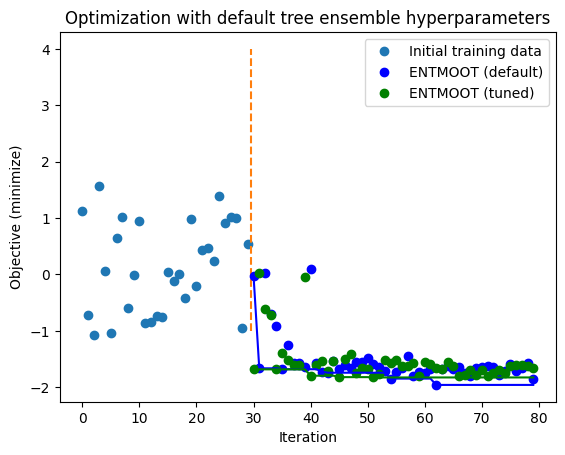

In [107]:
fig, ax = plt.subplots(1, 1)
ax.plot(
    np.arange(N_init_samples), rnd_sample_outcomes, "o", label="Initial training data"
)
ax.plot([N_init_samples - 0.5, N_init_samples - 0.5], [-1, 4], "--")
ax.plot(
    np.arange(N_iterations) + N_init_samples,
    opt_trajectory_outputs,
    "ob",
    label="ENTMOOT (default)",
)
ax.plot(
    np.arange(N_iterations) + N_init_samples,
    opt_trajectory_outputs_tuned,
    "og",
    label="ENTMOOT (tuned)",
)
ax.plot(
    np.arange(N_iterations) + N_init_samples,
    np.minimum.accumulate(opt_trajectory_outputs),
    "-b",
    label=None,
)
ax.plot(
    np.arange(N_iterations) + N_init_samples,
    np.minimum.accumulate(opt_trajectory_outputs_tuned),
    "-g",
    label=None,
)
ax.set_xlabel("Iteration")
ax.set_ylabel("Objective (minimize)")
ax.set_title("Optimization with default tree ensemble hyperparameters")
ax.legend()
plt.show()